In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from PIL import Image
import numpy as np
from gan import getGanModel
import cv2
import pandas as pd
import os
from tqdm import tqdm
import json
import shutil

In [2]:
def plotSaveImage(image, savePath = ''):
    data = (image.numpy() * 255)[0]
    plt.imshow(data)
    plt.show()
    if len(savePath):
        rescaled = (255.0 / data.max() * (data - data.min())).astype(np.uint8)
        im = Image.fromarray(rescaled)
        im.save(savePath)

In [3]:
def getImages(rootPath, imageList):
    images = []
    for i in imageList:
        temp = cv2.imread(os.path.join(rootPath, i))
        temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        temp = temp / 255
        images.append(temp)
    return np.array(images)

In [4]:
def getMetaData(rawData, start, batchSize, rootPath = ''):
    picNames = rawData[start:start+batchSize, 0]
    attributes = rawData[start:start+batchSize, 1:]
    attributes = np.asarray(attributes).astype('float32')
    attributes += 0.05 * np.random.random(attributes.shape)
    
    if len(rootPath):
        images = getImages(rootPath, picNames)
        return (images, attributes)
    return (picNames, attributes)

In [5]:
def copyCode(rootFolder):
    codeFiles = [
        "Discriminator.py",
        "Generator.py",
        "gan.py",
        "Train.py",
        "LoadModel.py",
        "DataPreprocess.py",
        "config.json"
    ]

    for eachFile in codeFiles:
        shutil.copy(eachFile, os.path.join(rootFolder, eachFile))


In [6]:
with open("config.json", "r") as f:
    jsonFile = json.load(f)
    CSVDetails = jsonFile['CSVDetails']
    dataset = jsonFile['ImageDetails']
    modelDetails = jsonFile['ModelDetails']

In [7]:
picsPath = os.path.join(dataset['ImageRootPath'], dataset['ImageProcessedImages']).replace("/", "\\")
csvPath = os.path.join(CSVDetails['CSVRootPath'], CSVDetails['CombinedCSV']).replace("/", "\\")
modelRootFolder = modelDetails['ModelRootFolder'].replace("/", "\\")
modelLog = os.path.join(modelRootFolder, modelDetails['ModelLog'])
PerformanceLog = os.path.join(modelRootFolder, modelDetails['PerformanceLog'])
modelCopy = os.path.join(modelRootFolder, modelDetails['TrainedModel'])
sampleOutput = os.path.join(modelRootFolder, modelDetails['SampleOutputs'])
codeCopy = os.path.join(modelRootFolder, modelDetails['CodeCopy'])

data = pd.read_csv(csvPath)
numpyData = data.values

randomNoiseLength = modelDetails['RandomVectorSize']
featuresLength = modelDetails['TotalAttributes']
batchSize = 25
start = 0
iterationsFrom = 0
iterations = 20
loop = 0

validationDataStart = len(numpyData) * 0.75
stepLimit = validationDataStart - batchSize
# stepLimit = 10000

saveModelInterval = 1
showImageInterval = 1
marginBetweenFakeReal = 50

controlSizeOfSampleImages = 6

gan, generator, discriminator = getGanModel()

In [8]:
if os.path.isdir(modelCopy):
#     gan.load_weights(os.path.join(modelCopy, 'gan_latest.h5'))
    generator.load_weights(os.path.join(modelCopy, 'generator_latest.h5'))
    discriminator.load_weights(os.path.join(modelCopy, 'discriminator_latest.h5'))

    with open(modelLog, 'r') as f:
        lastLine = f.read().splitlines()[-1]
    
    # Iterations, Discriminator Loss, Adversary Loss, Image number, Loop
    lastLine = lastLine.split(",")
    loop = int(lastLine[4])
    iterationsFrom = int(lastLine[0])
    start = int(lastLine[3]) # + batch size
    iterations = iterations - int(lastLine[0]) # optional
else:
    os.makedirs(modelCopy)
    os.makedirs(sampleOutput)
    os.makedirs(codeCopy)

    modelLogFile = open(modelLog, "w")
    modelLogFile.writelines("Iterations, Discriminator Loss, Adversary Loss, Image number, Loop\n")
    modelLogFile.close()

    pergormanceLogFile = open(PerformanceLog, "w")
    pergormanceLogFile.writelines("Iterations, HED Train, FID Train, HED Test, FED Test\n")
    pergormanceLogFile.close()

    copyCode(codeCopy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


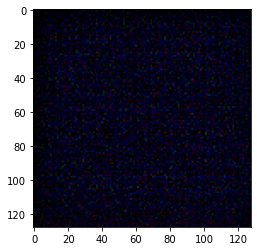

tf.Tensor([[0.4998439]], shape=(1, 1), dtype=float32)


In [9]:
# Test Generator image
features = tf.random.normal(shape=[1, featuresLength])
randomNoise = tf.random.normal(shape=[1, randomNoiseLength])
gImage = generator([features, randomNoise], training=False)
plotSaveImage(gImage)

decision = discriminator([features, gImage])
print(decision)

sampleStart = 0
sampleRealImages, sampleImagesAttributes = getMetaData(numpyData, sampleStart, controlSizeOfSampleImages**2, picsPath)
sampleRandomNoise = np.random.normal(size=(controlSizeOfSampleImages**2, randomNoiseLength))
sameSamples = False

In [10]:
tempSampleRealImages, tempSampleImagesAttributes = getMetaData(numpyData, 0, 50, picsPath)
tempSampleRandomNoise = np.random.normal(size=(50, randomNoiseLength))
tempSampleGeneratedImages = generator.predict([tempSampleImagesAttributes, tempSampleRandomNoise])

In [27]:
tempSampleRealImages

array([[[[0.58431373, 0.78039216, 0.78431373],
         [0.58431373, 0.78039216, 0.78431373],
         [0.58431373, 0.78039216, 0.78431373],
         ...,
         [0.91764706, 0.91764706, 0.9254902 ],
         [0.90980392, 0.91372549, 0.92156863],
         [0.90980392, 0.91372549, 0.92156863]],

        [[0.58431373, 0.78039216, 0.78431373],
         [0.58431373, 0.78039216, 0.78431373],
         [0.58431373, 0.78039216, 0.78431373],
         ...,
         [0.91372549, 0.91372549, 0.92156863],
         [0.90980392, 0.90980392, 0.91764706],
         [0.90588235, 0.90980392, 0.91764706]],

        [[0.58431373, 0.78039216, 0.78431373],
         [0.58431373, 0.78039216, 0.78431373],
         [0.58431373, 0.78039216, 0.78431373],
         ...,
         [0.91764706, 0.91764706, 0.91764706],
         [0.91372549, 0.91372549, 0.91372549],
         [0.91372549, 0.91372549, 0.91372549]],

        ...,

        [[0.57254902, 0.78431373, 0.79215686],
         [0.57254902, 0.78431373, 0.79215686]

In [49]:
# import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm

def getFIDScore(realImages, fakeImages):
    # Frechet Inception Distance
    length = len(realImages)
    
    average = 0
    
    for i in range(length):
        a = cv2.cvtColor(realImages[i], cv2.COLOR_BGR2GRAY)
        b = cv2.cvtColor(fakeImages[i], cv2.COLOR_BGR2GRAY)
        
        # calculate mean and covariance statistics
        mu1, sigma1 = a.mean(axis=0), cov(a, rowvar=False)
        mu2, sigma2 = b.mean(axis=0), cov(b, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        average = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return average / length

def getHEDScore(realImages, fakeImages):
    # Histogram Euclidean Distance
    length = len(realImages)
    
    average = 0
    
    for i in range(length):
        a = cv2.cvtColor(realImages[i], cv2.COLOR_BGR2GRAY)
        b = cv2.cvtColor(fakeImages[i], cv2.COLOR_BGR2GRAY)
        
        ah = cv2.calcHist([a],[0],None,[256],[0,256])
        bh = cv2.calcHist([b],[0],None,[256],[0,256])
        
        lengthh = min(len(ah), len(bh))
        
        count = 0
        j = 0
        while j<lengthh:
            count+=(ah[j][0]-bh[j][0])**2
            j+= 1
        average += count**(1 / 2)
    
    return average / length

In [50]:
getHEDScore(np.uint8(tempSampleRealImages * 255), np.uint8(tempSampleGeneratedImages * 255))

16391.719478711253

In [11]:
for step in tqdm(range(11, 21)):    
    # Fetching the images and their attributes from Hard drive
    realImages, attributes = getMetaData(numpyData, start, batchSize, picsPath)
    
    # Random vector (2nd Generator Input)
    randomVector = np.random.normal(size=(batchSize, randomNoiseLength))
    
    # Generating fake images
    generatedImages = generator.predict([attributes, randomVector])
    
    # Combining 50% fake and 50% real images as well as attributes for discriminator
    combinedImages = np.concatenate([generatedImages, realImages])
    combinedAttributes = np.concatenate([attributes, attributes])
    # 0 => Label for fake images, 1 => Label for real images >>> Used to train Discriminator
    labels = np.concatenate([np.zeros((batchSize, 1)), np.ones((batchSize, 1))])
    # labels += .05 * np.random.random(labels.shape)
    
    # Training Discriminator
    discriminatorLoss = discriminator.train_on_batch([combinedAttributes, combinedImages], labels)
    
    # Preparing to train Generator
    misleadingTargets = np.ones((batchSize, 1))
    misleadingTargets += .05 * np.random.random(misleadingTargets.shape)
    
#     # Random vector (2nd Generator Input)
#     randomVector = np.random.normal(size=(batchSize, randomNoiseLength))
    
    # Training Generator
    adversaryLoss = gan.train_on_batch([randomVector, attributes], misleadingTargets)
        
    if step % saveModelInterval == saveModelInterval - 1:
        gan.save_weights(os.path.join(modelCopy, 'gan_'+ str(step + 1) +'.h5'))
        generator.save_weights(os.path.join(modelCopy, 'generator_'+ str(step + 1) +'.h5'))
        discriminator.save_weights(os.path.join(modelCopy, 'discriminator_'+ str(step + 1) +'.h5'))

        # Preserve latest copy for easy access
        gan.save_weights(os.path.join(modelCopy, 'gan_latest.h5'))
        generator.save_weights(os.path.join(modelCopy, 'generator_latest.h5'))
        discriminator.save_weights(os.path.join(modelCopy, 'discriminator_latest.h5'))

        modelLogFile = open(modelLog, "a")
        modelLogFile.writelines("%d, %f, %f, %d, %d\n" % (step + 1, discriminatorLoss, adversaryLoss, start, loop))
        modelLogFile.close()

    if step % showImageInterval == showImageInterval - 1:
        log = 'Iterations: %d/%d, d_loss: %.4f,  a_loss: %.4f. ' % (step + 1, iterations, discriminatorLoss, adversaryLoss)
        print(log)

        if not sameSamples: # Generates different set of samples every time
            sampleRealImages, sampleImagesAttributes = getMetaData(numpyData, sampleStart, controlSizeOfSampleImages**2, picsPath)
            sampleRandomNoise = np.random.normal(size=(controlSizeOfSampleImages**2, randomNoiseLength))

        sampleStart = sampleStart + (controlSizeOfSampleImages**2)
        if sampleStart > stepLimit:
            sampleStart = 0

        sampleGeneratedImages = generator.predict([sampleImagesAttributes, sampleRandomNoise])

        controlGeneratedImage = np.ones((128 * controlSizeOfSampleImages, 128 * controlSizeOfSampleImages * 2 + marginBetweenFakeReal, 3))
        for i in range(controlSizeOfSampleImages**2):
            x_off = i % controlSizeOfSampleImages
            y_off = i // controlSizeOfSampleImages
            controlGeneratedImage[x_off * 128:(x_off + 1) * 128, y_off * 128:(y_off + 1) * 128, :] = sampleGeneratedImages[i, :, :, :]

        controlRealImage = np.ones((128 * controlSizeOfSampleImages, 128 * controlSizeOfSampleImages, 3))
        for i in range(controlSizeOfSampleImages**2):
            x_off = i % controlSizeOfSampleImages
            y_off = i // controlSizeOfSampleImages
            controlRealImage[x_off * 128:(x_off + 1) * 128, y_off * 128:(y_off + 1) * 128, :] = sampleRealImages[i, :, :, :]

        controlGeneratedImage[:, 128 * controlSizeOfSampleImages + marginBetweenFakeReal:, :] = controlRealImage
        
        im = Image.fromarray(np.uint8(controlGeneratedImage * 255))
      
        im.save(os.path.join(sampleOutput, str(step + 1) + ".png"))
        im.save(os.path.join(sampleOutput, "latest.tif"))

    start += batchSize
    if start > stepLimit:
        loop += 1
        start = 0

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Iterations: 12/10, d_loss: 0.6772,  a_loss: 0.4670. 


 10%|████████▎                                                                          | 1/10 [00:46<06:58, 46.53s/it]

Iterations: 13/10, d_loss: 1.4236,  a_loss: 1.0436. 


 20%|████████████████▌                                                                  | 2/10 [00:55<04:41, 35.24s/it]

Iterations: 14/10, d_loss: 0.6346,  a_loss: 1.2455. 


 30%|████████████████████████▉                                                          | 3/10 [01:05<03:14, 27.75s/it]

Iterations: 15/10, d_loss: 0.7123,  a_loss: 0.6484. 


 40%|█████████████████████████████████▏                                                 | 4/10 [01:16<02:16, 22.78s/it]

Iterations: 16/10, d_loss: 0.7078,  a_loss: 0.7271. 


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:36<01:49, 21.93s/it]

Iterations: 17/10, d_loss: 0.6859,  a_loss: 0.6998. 


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:46<01:13, 18.40s/it]

Iterations: 18/10, d_loss: 0.6673,  a_loss: 0.7023. 


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:57<00:48, 16.13s/it]

Iterations: 19/10, d_loss: 0.6851,  a_loss: 0.7140. 


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:10<00:30, 15.03s/it]

Iterations: 20/10, d_loss: 0.6606,  a_loss: 0.7699. 


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:19<00:13, 13.23s/it]

Iterations: 21/10, d_loss: 0.6681,  a_loss: 0.6192. 


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:39<00:00, 15.99s/it]


In [11]:
tempGeneratedImages = generatedImages * 255

plt.figure(1, figsize=(10, 10))
for i in range(batchSize):
    plt.subplot(5, 5, i+1)
    plt.imshow(tempGeneratedImages[i])
    plt.axis('off')
plt.show()


NameError: name 'generatedImages' is not defined